In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from common.utils import load_sql_to_df, plot_history, save_to_sql
from datasets import MoveAsTensorDataset
import board_representation as br

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from common.training import train_loop, test_model

import random

import chess
import chess.engine
from stockfish import Stockfish
import pandas as pd

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [24]:
def filter_func(row):
    board = chess.Board(row['position'])
    return board.is_legal(chess.Move.from_uci(row['move']))



# tables = ["classified_moves", "chessbase_moves_with_nags", "moves_from_books", "random_moves"]
# classified_moves = [load_sql_to_df(f"SELECT position, move, sentiment FROM {table_name}", "../../chess.db") for table_name in tables]
# classified_moves = pd.concat(classified_moves)
# classified_moves = classified_moves[classified_moves.apply(filter_func, axis=1)]

classified_moves = load_sql_to_df(f"SELECT position, move, sentiment FROM classified_moves", "../../chess.db")
classified_moves

,position,move,sentiment
0,2kr1b1r/ppp2ppp/2n5/4pb2/2P5/P1NP1PqP/1P4P1/R1...,e1d2,1
1,r1b3k1/5p1r/p7/q1n1Q2p/2p1P1p1/6P1/PP2N1BP/R4R...,c8b7,1
2,r1b2r2/p2n3k/1p4pp/2pp4/3P2Q1/P3P3/5PPP/2R3KR ...,d4c5,1
3,r2q4/2p2k2/P1p2pp1/2P5/3p3R/6Q1/P4PPK/8 b - - ...,f7g7,1
4,r1bqkbnr/p1p2ppp/3p4/2p1p3/2P1P3/5N2/PP1P1PPP/...,d2d3,1
...,...,...,...
2906272,3q1k2/3bpnr1/2p5/3pP3/1PpP1RPP/2BR4/3K2B1/1N6 ...,c6c5,0
2906273,3q1k2/3bpnr1/8/2ppP3/1PpP1RPP/2BR4/3K2B1/1N6 w...,g2h3,0
2906274,3q1k2/3bpnr1/8/2ppP3/1PpP1RPP/2BR3B/3K4/1N6 b ...,d7e8,0
2906275,3qbk2/4pnr1/8/2ppP3/1PpP1RPP/2BR3B/3K4/1N6 w -...,f4e4,0


In [27]:
train_df, test_df = train_test_split(classified_moves, test_size=0.01, random_state=0)
display(train_df)
display(test_df)

,position,move,sentiment
1483295,4rq2/pp5p/2p3k1/4B3/3p4/bP1P1NPB/2P5/3K1R2 b -...,h7h5,1
2691851,2b5/2pp1kr1/r1n2qpp/1p2p3/1PPbPpNP/R2B1P2/3K2P...,f6d6,0
641645,2b2k2/4nppp/pr6/2Q5/8/P7/1q3PPP/2R2RK1 w - - 1 22,c5c7,1
462046,2b1r3/p4kb1/4ppN1/2pq2nP/4pPQ1/1P2P1R1/PBP3P1/...,f4g5,0
2248513,1nbqkb2/2ppp1pr/r6n/pp3p1p/3PPP1P/1PP5/P5PR/RN...,a6b6,0
...,...,...,...
2249467,2brk2r/3pb1p1/1p2pq1n/P4P1p/1pQ1P1Pp/BP5B/R6R/...,h5g4,0
963395,r1b2rk1/ppp3b1/5n2/2q2ppn/4p3/2N1P2P/PPQNBBP1/...,g2g4,1
2215104,rnbqkbnr/pppppppp/8/8/P7/8/1PPPPPPP/RNBQKBNR b...,e7e5,0
1484405,2b2rk1/2r3n1/1q2pp1p/p2p2pP/1p1P2P1/1Pp1PN2/P1...,g8f7,1


,position,move,sentiment
2018817,r1b1k1nr/p1pp1pbp/1Qn5/4P1B1/1PP3P1/8/P2KPP1P/...,c6a5,0
463168,r4rk1/pp3ppp/1q6/3pP3/1P1n1P2/P2B1P2/5Q1P/2R2R...,f7f6,1
2774605,2r1kbr1/p3p1p1/b2Q1N2/1ppp2Pp/1q1P3N/2P2P2/4PK...,e7f6,0
2381725,rnb4r/1pppkppp/8/pN2pP2/1n1b3P/1P1P2q1/P1PKP1P...,c1b2,0
1706342,8/7p/1p2r1k1/2p5/6p1/P5Pq/1PP2P1P/4R1K1 w - - ...,e1e6,1
...,...,...,...
2239805,r1bq1b2/2p2krn/1p2p3/p2p1ppP/QPPnP3/3P1P1N/PB5...,g5g4,0
933141,5b1r/k3qp1p/b1nnpNp1/p2pP3/2pP4/B1P3Q1/P1B2PPP...,a3c5,1
68801,8/8/3k4/PP1p1p1b/3P1Pq1/2p1P3/2Q2KP1/8 w - - 1 43,a5a6,1
1100759,4r3/3k4/1ppB4/p2pPp2/P4N2/8/1P3K2/8 b - - 8 45,d5d4,1


In [28]:
train_dataset = MoveAsTensorDataset(train_df)
test_dataset = MoveAsTensorDataset(test_df)

In [29]:
class SentimateNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(26, 26, 5, padding='same'),
            nn.Dropout(0.25),
            nn.Conv2d(26, 26, 3, padding='same'),
            nn.Flatten()
        )

        self.fc_layers = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(8*8*26, 200),
            nn.ELU(),
            nn.Dropout(0.25),
            nn.Linear(200, 100),
            nn.ELU(),
            nn.Dropout(0.25),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [65]:
model = SentimateNet()
model = model.to(device)
# model = m)
model

SentimateNet(
  (conv_layers): Sequential(
    (0): Conv2d(26, 26, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
    (2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=200, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [66]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [67]:
train_loader = DataLoader(train_dataset, batch_size=4096)
test_loader = DataLoader(test_dataset, batch_size=4096)

In [70]:
# test_model(train_loader, model)
test_model(test_loader, model)

Test Error: Accuracy: 54.57%, Avg loss: 0.692054


In [71]:
len(train_loader)

703

In [72]:
def join_lists(dict1, dict2):
    result_dict = {}
    for key in dict1.keys():
        result_dict[key] = dict1[key] + dict2[key]
    return result_dict

In [74]:
history = train_loop(train_loader, model, val_dataloader=test_loader, num_epochs=40, optimizer=optimizer, verbose=True)

Epoch 1/40
Train loss: 0.423889, accuracy: 81.73%
Val loss:  0.408925, accuracy: 82.27%
-----------------------------
Epoch 2/40
Train loss: 0.413652, accuracy: 82.12%
Val loss:  0.406221, accuracy: 82.38%
-----------------------------
Epoch 3/40
Train loss: 0.411244, accuracy: 82.19%
Val loss:  0.404837, accuracy: 82.41%
-----------------------------
Epoch 4/40
Train loss: 0.409779, accuracy: 82.25%
Val loss:  0.403808, accuracy: 82.42%
-----------------------------
Epoch 5/40
Train loss: 0.408356, accuracy: 82.31%
Val loss:  0.402151, accuracy: 82.49%
-----------------------------
Epoch 6/40
Train loss: 0.406519, accuracy: 82.40%
Val loss:  0.399673, accuracy: 82.60%
-----------------------------
Epoch 7/40
Train loss: 0.404006, accuracy: 82.53%
Val loss:  0.396356, accuracy: 82.78%
-----------------------------
Epoch 8/40
Train loss: 0.400729, accuracy: 82.70%
Val loss:  0.391662, accuracy: 82.94%
-----------------------------
Epoch 9/40
Train loss: 0.396951, accuracy: 82.89%
Val lo

Test Error: Accuracy: 84.68%, Avg loss: 0.352265


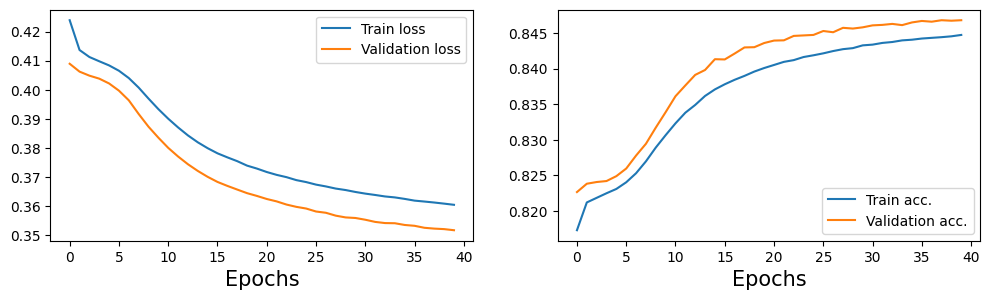

In [75]:
test_model(test_loader, model)
plot_history(history)

In [76]:
model

SentimateNet(
  (conv_layers): Sequential(
    (0): Conv2d(26, 26, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
    (2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=200, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [77]:
torch.save(model, "../../models/Sentimate_good.model")
# model.load_state_dict(torch.load("../../models/Sentimate_bad.model"))

In [22]:
model = torch.load("../../models/Sentimate_bad.model")
model

SentimateNet(
  (conv_layers): Sequential(
    (0): Conv2d(26, 13, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
    (2): Conv2d(13, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=200, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [23]:
test_model(train_loader, model)
test_model(test_loader, model)

Test Error: Accuracy: 69.13%, Avg loss: 0.594383
Test Error: Accuracy: 58.04%, Avg loss: 0.684526


In [ ]:
class Agent:
    def __init__(self) -> None:
        pass

    def play(self, board: chess.Board):
        pass

class ModelAgent(Agent):
    def __init__(self, model) -> None:
        super().__init__()
        self.model = model
        self.model_device = next(iter(model.parameters())).device
        self.model_dtype = next(iter(model.parameters())).dtype

    def batch_legal_moves(self, board: chess.Board):
        move_tensors = [br.move_to_tensor(board.fen(), move) for move in board.legal_moves]
        return torch.stack(move_tensors)

    def play(self, board: chess.Board):
        legal_moves = list(board.legal_moves)

        if len(legal_moves) == 0:
            return None
        
        batch_moves = self.batch_legal_moves(board).to(self.model_device, dtype=self.model_dtype)

        model.eval()
        with torch.inference_mode():
            out = model(batch_moves)
            best_move_ind = out.argmax().item()
            best_move = list(board.legal_moves)[best_move_ind]

            return best_move
        
class RandomAgent(Agent):
    def __init__(self) -> None:
        super().__init__()

    def play(self, board: chess.Board):
        legal_moves = list(board.legal_moves)

        if len(legal_moves) == 0:
            return None

        random_move = random.choice(legal_moves)

        return random_move

In [99]:
from collections import Counter

engine = chess.engine.SimpleEngine.popen_uci("stockfish")

def batch_legal_moves(board: chess.Board):
    move_tensors = [br.move_to_tensor(board.fen(), move) for move in board.legal_moves]
    return torch.stack(move_tensors)

def model_best_move(board: chess.Board, model: nn.Module):
    agent = ModelAgent(model)
    return agent.play(board)
    

def compare_moves(board, move1, move2):
    result1 = engine.analyse(board, chess.engine.Limit(time=0.2), root_moves=[move1])
    result2 = engine.analyse(board, chess.engine.Limit(time=0.2), root_moves=[move2])
    
    if result1["score"].relative > result2["score"].relative:
        return -1
    elif result1["score"].relative < result2["score"].relative:
        return 1
    else:
        return 0
    
def compare_model_to_random_agent(model: nn.Module, fens, random_moves_from_position = 1):
    results = []
    for fen in fens:
        board = chess.Board(fen)

        legal_moves = list(board.legal_moves)

        model_move = model_best_move(board, model)

        for _ in range(random_moves_from_position):
            random_move = random.choice(legal_moves)
            comparison = compare_moves(board, model_move, random_move)
            results.append(comparison)

    stats = Counter(results)

    return {"model_better": stats[-1], "random_better": stats[1], "draw": stats[0]}

In [25]:
#Old model (only gameknot, angelfire data)

pos_to_test = list(test_df.position.sample(n = 500, random_state=0))
compare_model_to_random_agent(model, pos_to_test)

{'model_better': 276, 'random_better': 217, 'draw': 7}

In [100]:
#Better model (chessbase, books, gameknot, angelfire, random moves)

pos_to_test = list(test_df.position.sample(n = 500, random_state=0))
compare_model_to_random_agent(model, pos_to_test)

{'model_better': 280, 'random_better': 194, 'draw': 26}

In [35]:
random_agent = RandomAgent()
model_agent = ModelAgent(model)

In [92]:
def play_game(white: Agent, black: Agent, n_moves = 40, verbose = False):
    board = chess.Board()

    if verbose:
        display(board)

    for i in range(n_moves):
        for agent in [white, black]:
            move = agent.play(board)

            if move == None:
                break

            board.push(move)

            if verbose:
                display(board)

    return board

def simple_result(board, time = 1):
    score = engine.analyse(board, chess.engine.Limit(time=time))['score'].white()

    if score <= chess.engine.Cp(-10):
        return -1
    elif score < chess.engine.Cp(10):
        return 0
    return 1

In [80]:
def test_agent(model_agent, n_games = 50, n_moves = 40, time = 1):
    random_agent = RandomAgent()
    results = []    

    for game in range(n_games//2):
        final_board = play_game(model_agent, random_agent, n_moves=40)
        score = simple_result(final_board, time=time)
        results.append(score)

    for game in range(n_games//2):
        final_board = play_game(random_agent, model_agent, n_moves=40)
        score = -simple_result(final_board, time=time)
        results.append(score)

    stats = Counter(results)

    return {"model_better": stats[1], "random_better": stats[-1], "draw": stats[0]}


In [63]:
test_agent(model_agent, n_games=100)    

{'model_better': 68, 'random_better': 30, 'draw': 2}

In [90]:
random_agent = RandomAgent()
model_agent = ModelAgent(model)

In [91]:
test_agent(model_agent, n_games=100)

{'model_better': 78, 'random_better': 22, 'draw': 0}